___

<a href='http://www.pieriandata.com'> <img src='../Pierian_Data_Logo.png' /></a>
___

# Bank stocks in crisis time

Recently, I was wondering how bank stocks reacted on crisis times. As we currently are in COVID-19 times, I would like to know more about this reaction. First, as a benchmark let's see how they reacted during the financial crisis since we already have some common knowledge about that. 

If I see some similarities, I might also include predicting the stock after the COVID crisis, referred to as COVID from now, based on an algo trained on the financial crisis, referred to as FC from now, data

Let's start importing the most important libs

In [1]:
# Analysis
import pandas as pd
import numpy as np
import datetime

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set(font='times new roman',font_scale=1,palette='Greens')

# Cut warnings for now
import warnings
warnings.filterwarnings('ignore')

## Data

Often I get my data from www.investing.com, or IEX/Google Finance in combination with Panda's data reader (https://pandas-datareader.readthedocs.io/en/latest/remote_data.html). Today however, let's use stooq since I do not want to publically show my API for either of these sources. Let's start gettig the data from 3 NL banks and 3 US banks (I want to include the US since the crisis was itnigthed by... maybe we see some lag in the Dutch stocks):

*European*
*  ING, Dutch (Rabobank is not AEX-listed)
*  Deutsche Bank, German
*  HSBC, English

*American*
* CitiGroup
* Goldman Sachs
* JPMorgan Chase



Let's first check which time frames we should consider for the two crises. I have done this with my 'old' method of just downloading a CSV from investing.com. 

Text(0.5, 1.0, 'COVID')

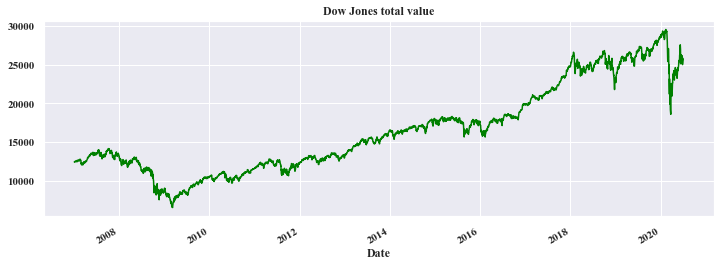

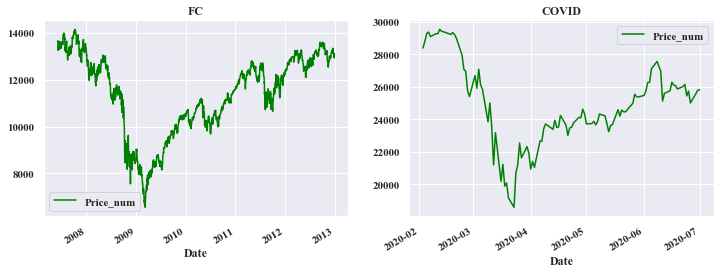

In [2]:
DowJ = pd.read_csv('DOW_JONES.csv',index_col=0)
DowJ['Price_num']=DowJ['Price'].apply(lambda x: float(x.split(',')[0]+x.split(',')[1]))
DowJ.index=pd.to_datetime(DowJ.index)
plt.figure()
DowJ['Price_num'].plot.line(figsize=(12,4),c='green',style="-")
plt.title('Dow Jones total value')

fig,axes=plt.subplots(nrows=1,ncols=2)
dates = (DowJ.index > datetime.datetime(2007,6,1)) & (DowJ.index <= datetime.datetime(2013,1,1))
DowJ.loc[dates].plot.line(figsize=(12,4),c='green',style="-",ax=axes[0])
axes[0].set_title('FC')
dates = (DowJ.index > datetime.datetime(2020,2,1)) & (DowJ.index <= datetime.datetime(2020,7,1))
DowJ.loc[dates].plot.line(figsize=(12,4),c='green',style="-",ax=axes[1])
axes[1].set_title('COVID')


Based on the Dow Jones we see that the same patterns occurs for both crises. However, the COVID crisis is much more abrupt. Let's set the end and start dates to perform some analysis for now.

It can be observed from the DowJones data that the recovery during the COVID crisis is much quicker compared to the financial crisis. My main question is, does this hold for the banking sector as well? Since I can imagine myself that the sector was hurt a lot the last crisis. Further, how accurately can we predict the recovery period of these crises with diffrent machine learning regression methods. 

In [3]:
date_start_FC=datetime.datetime(2008,1,1)
date_end_FC=datetime.datetime(2013,1,1)

date_start_COVID=datetime.datetime(2020,2,1)
date_end_COVID=datetime.datetime(2020,7,1) # I update this everytime I check this notebook

## Financial crisis (FC): Visualisation, analysis and prediction 

I used my own API to obtain the stock data from https://www.alphavantage.co/. The data is released by the API_Stock_reader.py. 

Now lets read it in again.

Text(0.5, 1, 'I am happy - no empties')

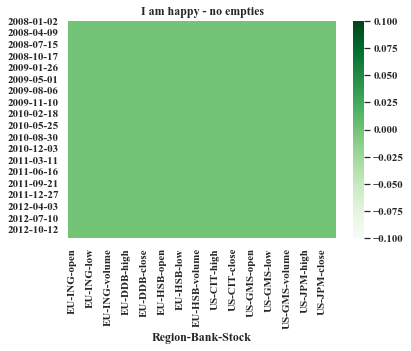

In [4]:
stocks_FC=pd.read_pickle('stocks_FC.csv')

ax=sns.heatmap(stocks_FC.isna(),cmap='Greens')
ax.set_title('I am happy - no empties')

If I check the values of the stocks, I note that the US banks are on average larger compared to the EU banks

In [5]:
stocks_FC.xs('close', level='Stock', axis=1).describe()

Region           EU                                     US               \
Bank            ING          DDB          HSB          CIT          GMS   
count   1259.000000  1259.000000  1259.000000  1259.000000  1259.000000   
mean      13.373384    59.884702    53.010238    16.327830   137.972062   
std        9.177184    23.395565    13.435209    13.166381    32.605736   
min        3.030000    21.270000    23.590000     1.020000    52.000000   
25%        8.350000    42.220000    44.095000     4.060000   113.040000   
50%        9.840000    57.850000    51.010000    11.820000   141.870000   
75%       12.650000    70.775000    56.015000    28.005000   164.920000   
max       40.400000   129.060000    87.670000    44.200000   207.780000   

Region               
Bank            JPM  
count   1259.000000  
mean      38.851347  
std        5.598501  
min       15.900000  
25%       35.830000  
50%       39.840000  
75%       42.890000  
max       49.850000

Text(0.5, 1.0, 'Boxplot - Absolute stock price for the six banks during the FC')

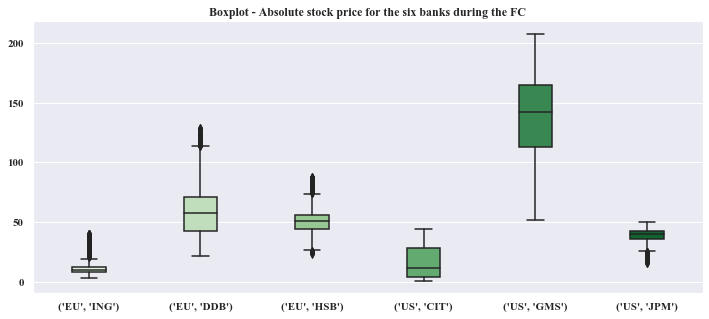

In [6]:
stocks_FC_close = stocks_FC.xs('close', level='Stock', axis=1)
plt.figure(figsize=(12,5))
ax1=sns.boxplot(data=stocks_FC_close[['EU','US']],width=0.3)
ax1.set_title('Boxplot - Absolute stock price for the six banks during the FC')

The boxplot shows the mean and the variance for the different banks. However, the stock price should be normalised (i.e. I should take the percental difference) to make a fair comparison.

$$\Delta p_t [\%] = 100\frac{p_t - p_{t-1}}{p_{t-1}} = 100(\frac{p_t}{p_{t-1}} - 1)$$

In [7]:
stocks_FC_close_change = stocks_FC_close.pct_change()*100

## I have observed a very high value for Citigroup (Order 800-900%) why??
stocks_FC_close_change.index=pd.to_datetime(stocks_FC_close_change.index)
dates = (stocks_FC_close_change.index > datetime.datetime(2011,5,2)) & (stocks_FC_close_change.index <= datetime.datetime(2011,5,13))
stocks_FC_close_change.loc[dates]



Region            EU                              US                    
Bank             ING       DDB       HSB         CIT       GMS       JPM
2011-05-03 -0.151057 -1.765428  0.091929    0.668151  0.376735  1.637893
2011-05-04 -1.739788 -0.343804 -0.844967   -0.110619 -0.230460 -0.914634
2011-05-05 -0.384911 -2.901051 -1.519081   -0.775194 -0.732577 -0.725275
2011-05-06 -2.009274 -2.147933 -0.225734    0.892857 -0.206103 -0.287802
2011-05-09 -2.365931  0.214557 -0.056561  876.991150 -0.652898 -0.177620
2011-05-10  4.604200  2.173913  1.282777    0.090580  0.858369  0.444840
2011-05-11 -2.471042 -2.369439 -1.378283   -2.895928 -1.675532 -2.059345
2011-05-12 -0.395883  1.007099 -0.245515   -1.164958 -3.469029 -0.316527
2011-05-13 -3.418124 -3.285387 -0.530102   -2.098067 -0.903678 -2.132003

In [8]:
stocks_FC_close.loc[dates]

Region         EU                    US               
Bank          ING    DDB    HSB     CIT     GMS    JPM
2011-05-03  13.22  63.99  54.44   4.520  151.87  45.92
2011-05-04  12.99  63.77  53.98   4.515  151.52  45.50
2011-05-05  12.94  61.92  53.16   4.480  150.41  45.17
2011-05-06  12.68  60.59  53.04   4.520  150.10  45.04
2011-05-09  12.38  60.72  53.01  44.160  149.12  44.96
2011-05-10  12.95  62.04  53.69  44.200  150.40  45.16
2011-05-11  12.63  60.57  52.95  42.920  147.88  44.23
2011-05-12  12.58  61.18  52.82  42.420  142.75  44.09
2011-05-13  12.15  59.17  52.54  41.530  141.46  43.15

Stock almost when times 10. Citigroup reversed the stock plit at this date, see https://money.cnn.com/2011/03/21/news/companies/citigroup_reverse_stock_split/index.htm#:~:text=NEW%20YORK%20(CNNMoney)%20%2D%2D%20Citigroup,Stock%20Exchange%20on%20May%209.

Now let's set that percentual change to zero and make the box plots.

Text(0.5, 1.0, 'Boxplot - Percental stock change for the six banks during the FC')

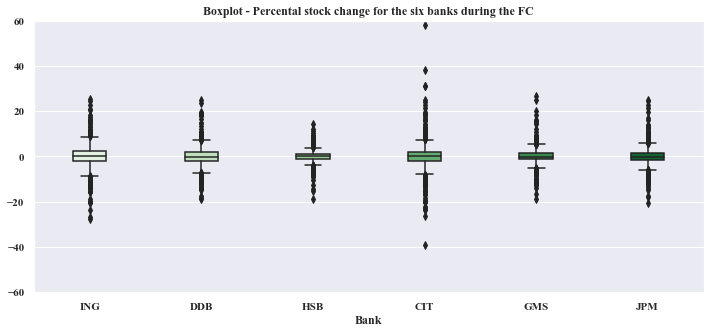

In [9]:
stocks_FC_close_change[stocks_FC_close_change>800]=0

plt.figure(figsize=(12,5))
ax1=sns.boxplot(data=stocks_FC_close_change.droplevel('Region', axis=1),width=0.3)
ax1.set_ylim([-60,60])
ax1.set_title('Boxplot - Percental stock change for the six banks during the FC')

It can be noted that the majority of the daily changes lies between $\pm5\%$. However, CitiGroup has a lot of (high!) outliers in the order of 30-40$\%$. After some google search it appears to be crashed very hard, e.g. https://www.reuters.com/article/us-citigroup/citigroup-stock-falls-below-1-for-first-time-idUSN0532847720090305
Let's see whether this can also be observed in the pairplots.

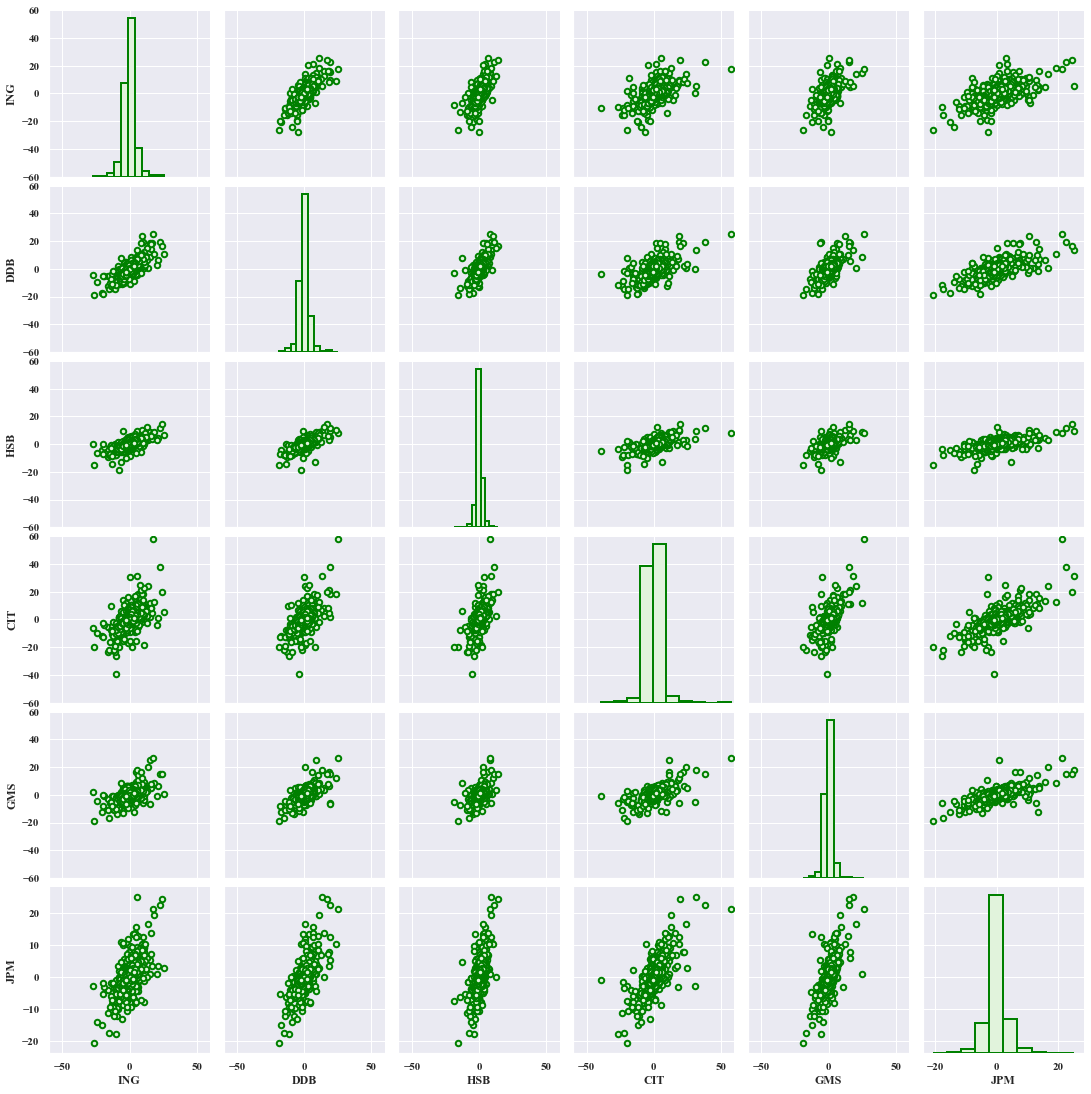

In [10]:
pair_plot=sns.pairplot(stocks_FC_close_change.droplevel('Region', axis=1), plot_kws=dict(s=30, edgecolor="g", linewidth=2),diag_kws=dict(edgecolor='g',linewidth=2))


for i in range(0,5):
    for j in range(0,5):
        pair_plot.axes[i,j].set_ylim(-60,60)
        pair_plot.axes[i,j].set_xlim(-60,60)


Same story, but when was this? Let's check that out

In [11]:
stocks_FC_close_change.min()

Region  Bank
EU      ING    -27.551020
        DDB    -18.940549
        HSB    -18.821839
US      CIT    -39.024390
        GMS    -18.959617
        JPM    -20.727432
dtype: float64

The twentieth of January 2009 seems to be a remarkable day. A quick search resulted in the following fact: this was the first day Obama worked @ the white house. Coincidence?!

Now let's check growth. 

In [12]:
stocks_FC_close_change.idxmax()

Region  Bank
EU      ING    2010-05-10
        DDB    2008-11-24
        HSB    2009-03-23
US      CIT    2008-11-24
        GMS    2008-11-24
        JPM    2009-01-21
dtype: datetime64[ns]

It can be seen that peak-growth-days are quite spread. This could indicate that the recovery is quite smoothend out. Lets see the what the standard deviations say.

In [13]:
stocks_FC_close_change.std()

Region  Bank
EU      ING     4.713017
        DDB     3.987221
        HSB     2.423218
US      CIT     5.276861
        GMS     3.237545
        JPM     3.682116
dtype: float64

Over the FC crisis the above standard deviations of the percentual change shows that CIT is the riskiest as would be expected. It's suprising that ING is also quite risky. 

Let's now consider a 'recovery year'. Let's say 2012-2013. What would be the riskiest bank to invest in? And the savest?

In [14]:
dates_FCrec = (stocks_FC_close_change.index > datetime.datetime(2012,1,1)) & (stocks_FC_close_change.index <= datetime.datetime(2013,1,1))
stocks_FC_close_change.loc[dates_FCrec]
stocks_FC_close_change.loc[dates_FCrec].std()

Region  Bank
EU      ING     2.891623
        DDB     2.759455
        HSB     1.356868
US      CIT     2.289936
        GMS     1.798209
        JPM     1.810336
dtype: float64

Citigroup recovered quite stable. Also in line with other US banks. ING and DDB do bad. Lets see how the histograms compare for that year.

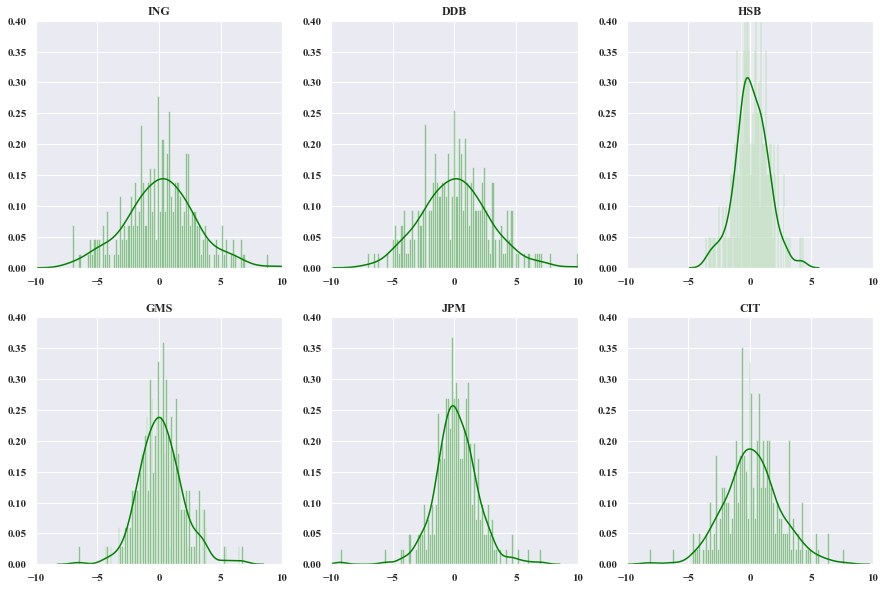

In [15]:
banks='ING DDB HSB CIT GMS JPM'.split()
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(15,10))
row=0
col=0
for bank in banks:
    sns.distplot(stocks_FC_close_change.loc[dates_FCrec].xs(bank,level='Bank',axis=1),color='green',bins=100,ax=axes[row][col])
    axes[row][col].set_title(bank)
    axes[row][col].set_xlim([-10, 10])
    axes[row][col].set_ylim([0, 0.4])
    

    if col==2:
        col-=3
        row+=1
    else:
        col+=1

Here we can see that the EU banks are in general safer. But do we see some correlation between the EU and US banks?

Text(0.5, 1, 'Correlation of stock prices between 2006 and 2013')

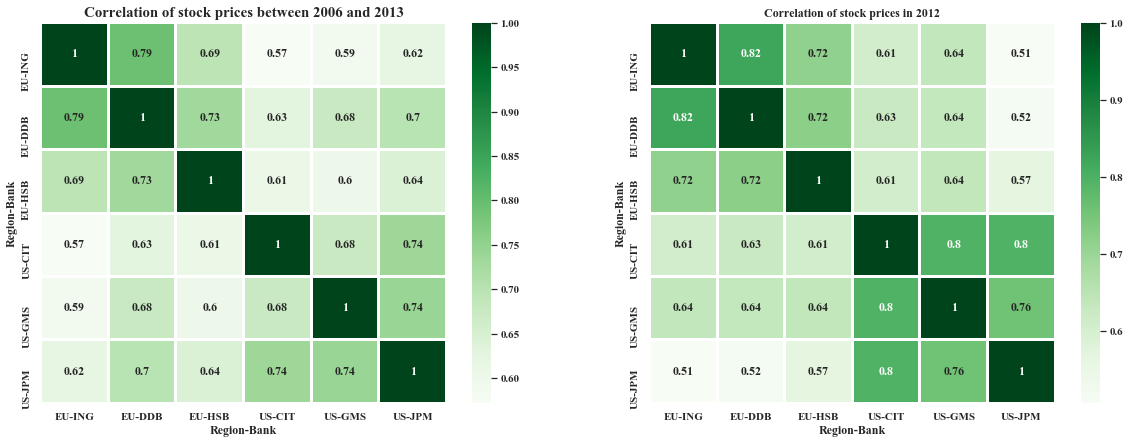

In [16]:
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(20,7))
sns.heatmap(stocks_FC_close_change.loc[dates_FCrec].corr(),annot=True,ax=axes[1],linewidths=2,cmap='Greens')
axes[1].set_title('Correlation of stock prices in 2012')
sns.heatmap(stocks_FC_close_change.corr(),annot=True,ax=axes[0],linewidths=2,cmap='Greens')
axes[0].set_title('Correlation of stock prices between 2006 and 2013',fontsize=15)


For both periods it can be seen that banks from the same region have a high correlations compared to overseas banks. This is of course quite logical since they are listed to the same stock exchange. Furthermore, one can see that the correlation in the smaller time window is larger compared to the larger time window which is as expected. Remarkable is that the EU banks (almost) always have a higher correlated compared to eachother compared to the US banks.

____
# Time series
Now, lets have a detailed look at the time series themselves. For stock visualisation purposes it is often quite handy to plot them interactively. Let's do that here using the Plotly and Cufflinks libraries.

In [17]:
# Optional Plotly Method Imports
import plotly
import cufflinks as cf
cf.go_offline()

stocks_FC_close.xs(bank,level='Bank',axis=1) # We want to plot this

Region,US
2008-01-02,42.1700
2008-01-03,41.8800
2008-01-04,40.9300
2008-01-07,41.3400
2008-01-08,39.7000
...,...
2012-12-24,43.9200
2012-12-26,43.9600
2012-12-27,43.6300
2012-12-28,43.2400


In [18]:
ax=plt.figure()
ax=stocks_FC_close.droplevel('Region', axis=1).iplot()

<Figure size 432x288 with 0 Axes>

Here we clearly see the drop in all stocks in 2008 and the recovery afterwards. Also clear is the increase in exchange rate of CIT in March 2011 - we have identified this earlier! For further purposes I would like to consider the recovery part of the spectrum.

Let's zoom in on that a bit:

In [19]:
dates_FCrec_2 = (stocks_FC_close_change.index > datetime.datetime(2009,3,13)) & (stocks_FC_close_change.index <= datetime.datetime(2009,10,13))

ax=plt.figure()
ax=stocks_FC_close[dates_FCrec_2].droplevel('Region', axis=1).iplot()

<Figure size 432x288 with 0 Axes>

Here the recovery period is shown. One can see that some banks recover quicker or more stable than others. Now let's see how quick that is for each bank using linear regression.

In [20]:
stocks_FC_close = stocks_FC_close.droplevel(level='Region',axis=1)
stocks_FC_close


Bank,ING,DDB,HSB,CIT,GMS,JPM
2008-01-02,38.25,129.06,82.44,28.92,207.60,42.1700
2008-01-03,38.23,128.90,82.42,28.93,204.84,41.8800
2008-01-04,37.42,127.65,81.25,28.24,199.93,40.9300
2008-01-07,37.87,127.82,82.16,28.26,194.73,41.3400
2008-01-08,36.92,124.00,80.60,27.14,189.50,39.7000
...,...,...,...,...,...,...
2012-12-24,9.22,43.54,52.69,39.38,127.54,43.9200
2012-12-26,9.22,43.45,52.81,39.55,127.16,43.9600
2012-12-27,9.43,44.37,52.79,39.25,126.67,43.6300
2012-12-28,9.17,43.32,52.54,39.01,125.52,43.2400


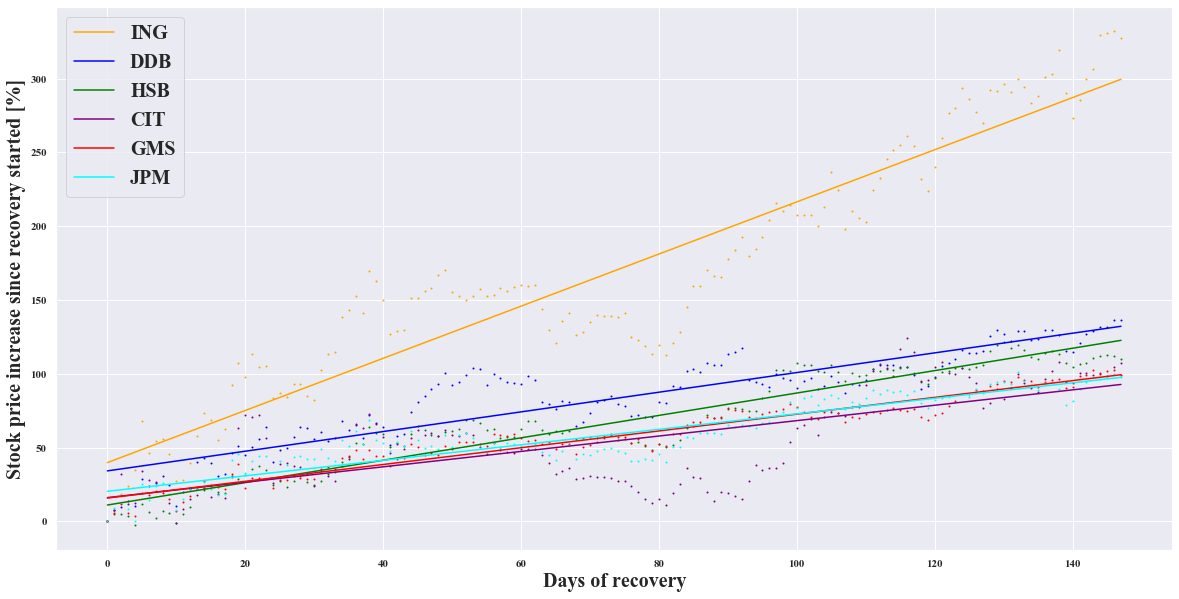

In [21]:
colors=['orange','blue','green','purple','red','cyan']
plt.figure(figsize=(20,10))
lin_coef_FC=[]  # This is for later reference

for i in range(0,len(banks)):
    price = (stocks_FC_close[dates_FCrec_2][banks[i]].values/stocks_FC_close[dates_FCrec_2][banks[i]].values[0]-1)*100
    days_from_start = np.arange(0,len(price))
    linFit = np.polyfit(days_from_start,price,1) # Some good old numpy fitting
    lin_coef_FC.append(linFit[0])
    
    plt.scatter(days_from_start,price,c=colors[i],s=1)
    plt.plot([days_from_start[0],days_from_start[-1]],[linFit[0]*days_from_start[0]+linFit[1],linFit[0]*days_from_start[-1]+linFit[1]],c=colors[i],label=banks[i])
    plt.legend(fontsize=20)
    plt.ylabel('Stock price increase since recovery started [%]', fontsize=20)
    plt.xlabel('Days of recovery', fontsize=20)

Not that all ploints were normalised at t=0 before fitting. It can clearly be seen that ING is a very quick recoverer. This can generally be said for all EU banks. The US banks in general recover much slower. The coefficients of the lines are stored and will be compared to the coefficients of the COVID period to compared the two crises.

Now, let's focus on the predictability of the stocks of the different banks during the same period. Let's start by shifting the data since we know if we shift it, 'the true value in two days' is known. The number two is arbirary and will be changed later. I expect that the predictability would be better is the number of forecast days is smaller. 

In [22]:
forecast_days = 2

stocks_FC_close_pred=stocks_FC_close[dates_FCrec_2].shift(-forecast_days)
stocks_FC_close_pred

Bank,ING,DDB,HSB,CIT,GMS,JPM
2009-03-16,5.03,37.24,28.28,3.08,105.25,27.11
2009-03-17,5.28,38.71,27.90,2.60,99.30,24.95
2009-03-18,5.73,37.51,26.23,2.62,97.32,23.15
2009-03-19,7.13,43.77,30.01,3.13,111.93,28.86
2009-03-20,6.22,42.10,28.60,2.98,110.63,26.40
...,...,...,...,...,...,...
2009-10-07,18.32,78.60,57.32,4.63,189.30,45.85
2009-10-08,18.36,80.19,57.03,4.77,190.15,46.08
2009-10-09,18.18,80.09,56.43,4.83,187.23,45.66
2009-10-12,NaN,NaN,NaN,NaN,NaN,NaN


The shifting works as one can see above. 

I would like to use linear regression, supported vector machines and supported vector machines in combination with a grid search (personally I find a grid search quite ugly, I would rather go for a steepest decent or latin hyper cube optimisation but this problem is some small with only two dimension that a grid search is sufficient).

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

## INITIALISE LISTS OF R2 OF THE DIFFERENT MODELS
linReg_R2=[]
SVR_R2=[]
SVR_GS_R2=[]


forecast_days = np.array([3, 10, 20])  # Amount of forecast days
R2_values=np.zeros((len(banks)+1,3*len(forecast_days))) # The matrix to be filled


for j in range(0,len(forecast_days)):
    stocks_FC_close_pred=stocks_FC_close[dates_FCrec_2].shift(-forecast_days[j])

    for i in range(0,len(banks)):
        ## SPLIT THE DATA
        X=np.array(stocks_FC_close[dates_FCrec_2][banks[i]])
        X=X[:-forecast_days[j]] # Here we shift it

        y=np.array(stocks_FC_close_pred[banks[i]])
        y=y[:-forecast_days[j]]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

        ## LINEAR REGESSION
        linMod = LinearRegression()
        linMod.fit(X_train.reshape(-1, 1),y_train)
        linReg_R2.append(linMod.score(X_test.reshape(-1, 1),y_test))
        R2_values[i,0+3*j]=linMod.score(X_test.reshape(-1,1),y_test)

        ## SVR
        SVRmodel = SVR(kernel='rbf', C=1e3, gamma=0.1)
        SVRmodel.fit(X_train.reshape(-1, 1),y_train)
        SVR_R2.append(SVRmodel.score(X_test.reshape(-1,1),y_test))
        R2_values[i,1+3*j]=SVRmodel.score(X_test.reshape(-1,1),y_test)
        
        ## SVR WITH GRID SEARCH
        param_grid={'C':[0.1,1,10,100,1000],'gamma':[1,0.1,0.01,0.001,0.0001]}

        GridSVR = GridSearchCV(SVR(), param_grid,verbose=0) ## One can change verbose to 3 if you need info over the GS
        GridSVR.fit(X_train.reshape(-1,1),y_train)
        SVR_GS_R2.append(GridSVR.score(X_test.reshape(-1,1),y_test))
        R2_values[i,2+3*j]=GridSVR.score(X_test.reshape(-1,1),y_test)
        
        

    R2_values[i+1,0+3*j]=np.mean(linReg_R2)
    R2_values[i+1,1+3*j]=np.mean(SVR_R2)
    R2_values[i+1,2+3*j]=np.mean(SVR_GS_R2)
R2_values

array([[ 0.92524992,  0.9311921 ,  0.92465076,  0.90613182,  0.76150426,
         0.79743112,  0.71182039,  0.80540708,  0.80458784],
       [ 0.90340019,  0.71414124,  0.90214508,  0.69323117,  0.64402109,
         0.68643301,  0.46472114,  0.40548613,  0.41928213],
       [ 0.93864809,  0.92398634,  0.93539806,  0.84404784,  0.87435046,
         0.88459808,  0.73582295,  0.73919763,  0.75773375],
       [ 0.85717337,  0.88139475,  0.8706318 ,  0.29366041,  0.26026255,
         0.28323156,  0.15952932,  0.27832369,  0.24147481],
       [ 0.96075397,  0.84455036,  0.92945341,  0.8511924 ,  0.67871224,
         0.84169047,  0.80489391,  0.4700145 ,  0.815025  ],
       [ 0.92349468, -0.0415552 ,  0.91493127,  0.83391147, -0.69393833,
         0.77472731,  0.4020121 ,  0.5729063 ,  0.40461607],
       [ 0.91812004,  0.7089516 ,  0.9128684 ,  0.82757461,  0.56488516,
         0.81211016,  0.73387195,  0.55833095,  0.73266897]])

In [24]:
col_names = [np.array(['3', '3', '3', '10', '10', '10', '20', '20' , '20']),np.array(['linReg', 'SVR', 'SVR_GS', 'linReg', 'SVR', 'SVR_GS','linReg', 'SVR', 'SVR_GS'])]
R2_DF_FC = pd.DataFrame(R2_values,columns=col_names,index=['ING', 'DDB', 'HSB', 'CIT', 'GMS', 'JPM', 'Average'])
R2_DF_FC.columns.names=['n_predictionDays','PredictionMethod']
R2_DF_FC

n_predictionDays         3                            10                      \
PredictionMethod    linReg       SVR    SVR_GS    linReg       SVR    SVR_GS   
ING               0.925250  0.931192  0.924651  0.906132  0.761504  0.797431   
DDB               0.903400  0.714141  0.902145  0.693231  0.644021  0.686433   
HSB               0.938648  0.923986  0.935398  0.844048  0.874350  0.884598   
CIT               0.857173  0.881395  0.870632  0.293660  0.260263  0.283232   
GMS               0.960754  0.844550  0.929453  0.851192  0.678712  0.841690   
JPM               0.923495 -0.041555  0.914931  0.833911 -0.693938  0.774727   
Average           0.918120  0.708952  0.912868  0.827575  0.564885  0.812110   

n_predictionDays        20                      
PredictionMethod    linReg       SVR    SVR_GS  
ING               0.711820  0.805407  0.804588  
DDB               0.464721  0.405486  0.419282  
HSB               0.735823  0.739198  0.757734  
CIT               0.159529  0.278324  0.241475  
GMS               0.804894  0.470014  0.815025  
JPM               0.402012  0.572906  0.404616  
Average           0.733872  0.558331  0.732669

From the above we can observe that the more days we predict in advance, the less accurate we get. However, we can still quite confidentially predict the stocks in the recovering period for 20 days. It can be observed that in almost all cases the Supported Vector Regression in combination with a Grid Search is most optimal. Remarkable is that a linear regression also does very well. 

Further, the GMS and ING are very predictable. This is in line with what we have seen earlier. Citigroup is by far the most unpredicatble and would be a risky investment but has significant returns as we have seen earlier.

## Corona Crisis (COVID): Visualisation, analysis, and predictions

Now let's perform a similar procedure as done above for the Financial Crisis (FC). In the beginning of this section I am not going to reflect that much on the results - one can do that by themselves by means of the reasoning of the previous section. Interesting and relevant will be dotted down of course.

Text(0.5, 1, 'I am happy - no empties')

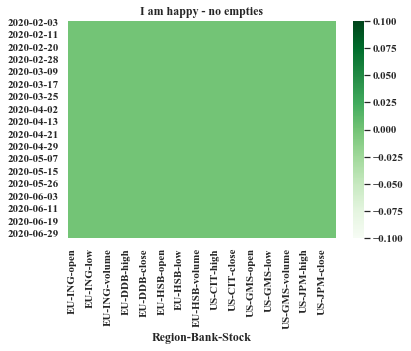

In [25]:
stocks_COVID=pd.read_pickle('stocks_COVID.csv')

ax=sns.heatmap(stocks_COVID.isna(),cmap='Greens')
ax.set_title('I am happy - no empties')

We again do not see any empty rows of colums, nice.

In [26]:
stocks_COVID.xs('close', level='Stock', axis=1).describe()

Region          EU                                  US                        
Bank           ING         DDB         HSB         CIT         GMS         JPM
count   105.000000  105.000000  105.000000  105.000000  105.000000  105.000000
mean      7.056952    7.937143   28.035048   52.732762  191.510952  102.275429
std       2.118501    1.594185    4.678729   12.559495   26.840385   16.823090
min       4.700000    5.480000   22.970000   35.390000  134.970000   79.030000
25%       5.320000    6.540000   24.540000   43.800000  176.030000   90.640000
50%       6.510000    7.510000   25.730000   49.160000  187.010000   95.820000
75%       7.930000    9.340000   30.450000   58.860000  208.740000  108.080000
max      11.780000   11.040000   38.600000   79.330000  244.300000  138.000000

As we see here, the total length of the COVID crisis is lower compared to the FC. Logical, since we are currently in the crisis. Further, one should not that the stocks levels are on average higher compared to the FC, this is in line with the general trend of all the indices.

Text(0.5, 1.0, 'Boxplot - Absolute stock price for the six banks during the COVID')

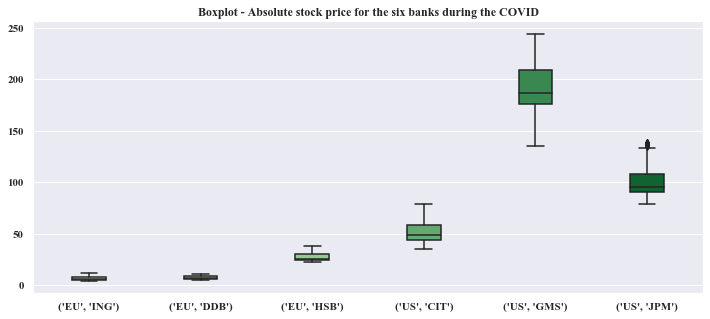

In [27]:
stocks_COVID_close = stocks_COVID.xs('close', level='Stock', axis=1)
plt.figure(figsize=(12,5))
ax1=sns.boxplot(data=stocks_COVID_close[['EU','US']],width=0.3)
ax1.set_title('Boxplot - Absolute stock price for the six banks during the COVID')

Text(0.5, 1.0, 'Boxplot - Percental stock change for the six banks during COVID')

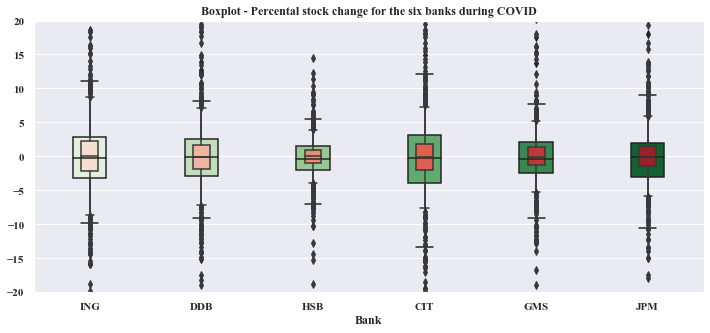

In [28]:
stocks_COVID_close_change = stocks_COVID_close.pct_change()*100

plt.figure(figsize=(12,5))
ax1=sns.boxplot(data=stocks_COVID_close_change.droplevel('Region', axis=1),width=0.3)
ax1=sns.boxplot(data=stocks_FC_close_change.droplevel('Region', axis=1),width=0.15,palette='Reds')

ax1.set_ylim([-20,20])
ax1.set_title('Boxplot - Percental stock change for the six banks during COVID')

Interesting, one sees that the green boxes (COVID) are larger compared to the FC. Further, the extrema are much lower - in the order of 20% for COVID, in the FC in the order of 30-40%. This shows that the variance in the FC is larger compared to the COVID crisis, let's verify this in a bit.

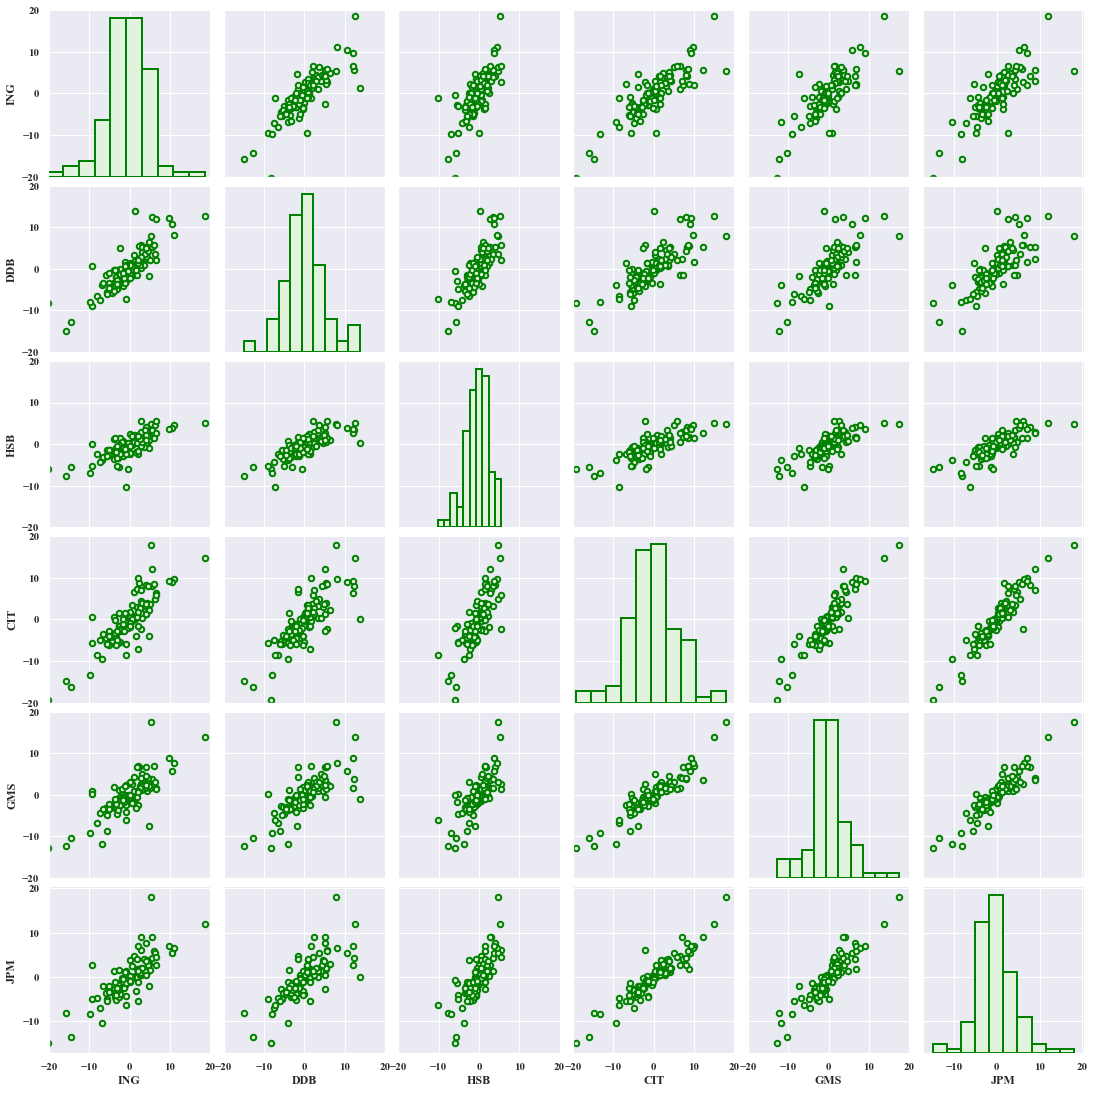

In [29]:
pair_plot=sns.pairplot(stocks_COVID_close_change.droplevel('Region', axis=1), plot_kws=dict(s=30, edgecolor="g", linewidth=2),diag_kws=dict(edgecolor='g',linewidth=2))


for i in range(0,5):
    for j in range(0,5):
        pair_plot.axes[i,j].set_ylim(-20,20)
        pair_plot.axes[i,j].set_xlim(-20,20)


I can not identify one 'outlier' as we saw for Citigroup in the FC. Of course one can recognise that all variable have some correlation, some more than others, but all of them have. This is of course since they are all listed stocks and all world wide stocks in a similar sector are somehow correlated.

In [30]:
stocks_COVID_close_change.min()

Region  Bank
EU      ING    -20.325203
        DDB    -15.053763
        HSB    -10.246341
US      CIT    -19.298589
        GMS    -12.705311
        JPM    -14.964873
dtype: float64

All these maximum drops are lower compared to the maximum drops of the FC which are all O(20%) and Citi 40%. This means that the drop in the COVID crisis in the banking sector was not that abrupt. It would be interesting to also compare other industies but that out of the scope of this project.

When was this drop?

In [31]:
stocks_COVID_close_change.idxmin()

Region  Bank
EU      ING     2020-03-16
        DDB     2020-03-12
        HSB     2020-04-01
US      CIT     2020-03-16
        GMS     2020-03-16
        JPM     2020-03-16
dtype: object

Almost all banks dropped at the 16th of March 2020, this was the 20th of Jan 2009 in the FC. This is the day I got into problems in the Fillipins :(

In [32]:
stocks_COVID_close_change.std()


Region  Bank
EU      ING     5.423772
        DDB     5.069948
        HSB     2.912437
US      CIT     6.042601
        GMS     4.666429
        JPM     4.771973
dtype: float64

We see that the standard deviation for this period is very high. Also compared to the FS these numbers are all at least 25% higher. This means that there were a lot of larger $\pm$ changes during the COVID crisis. This is also what I observed when following the stocks during the COVID crisis. One of the reasons for this could be the enourmous amounts of (fake) news during these times.

From now on, let's also focus on the recovery period since that's the period I am particularly interested in.


In [33]:
stocks_COVID_close_change.index=pd.to_datetime(stocks_COVID_close_change.index)

dates_COVIDrec = (stocks_COVID_close_change.index > datetime.datetime(2020,3,17)) & (stocks_COVID_close_change.index <= datetime.datetime(2020,7,1))
stocks_COVID_close_change.loc[dates_COVIDrec]
stocks_COVID_close_change.loc[dates_COVIDrec].std()

Region  Bank
EU      ING     5.082603
        DDB     4.691297
        HSB     2.803126
US      CIT     5.501337
        GMS     4.182234
        JPM     4.161763
dtype: float64

Here the difference in standard deviation compared to the FC is even larger. In the order of a different of 100%. In other words, the variance in the recovery period of the COVID crisis is double the variance of the variance during the recovery period of the FC for all banks. This means that this is a highly uncertain and risky, but also potentially profitable period for investors. 

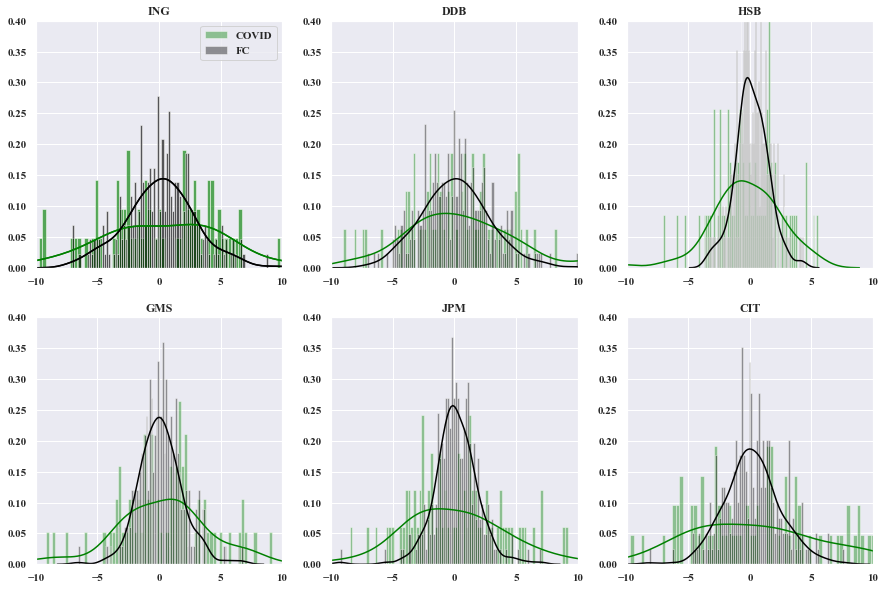

In [34]:
banks='ING DDB HSB CIT GMS JPM'.split()
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(15,10))
row=0
col=0
for bank in banks:
    sns.distplot(stocks_COVID_close_change.loc[dates_COVIDrec].xs(bank,level='Bank',axis=1),color='green',bins=100,ax=axes[row][col])
    sns.distplot(stocks_FC_close_change.loc[dates_FCrec].xs(bank,level='Bank',axis=1),color='black',bins=100,ax=axes[row][col])

    axes[row][col].set_title(bank)
    axes[row][col].set_xlim([-10, 10])
    axes[row][col].set_ylim([0, 0.4])
    

    if col==2:
        col-=3
        row+=1
    else:
        col+=1
sns.distplot(stocks_COVID_close_change.loc[dates_COVIDrec].xs('ING',level='Bank',axis=1),color='green',bins=100,ax=axes[0][0],label='COVID')
sns.distplot(stocks_FC_close_change.loc[dates_FCrec].xs('ING',level='Bank',axis=1),color='black',bins=100,ax=axes[0][0],label='FC')

axes[0][0].legend()

plt.savefig('Figures/PCA_dist_log.png',quality=50,format='png')

What a huge difference in percentual change percentages - here we indeed see that the variances for COVID are much smaller. The same hold for the maxima in the FC: the are much larger. So the recovery of the FC was much more less spicky - during the COVID crsis we see a lot of $\pm5\%$ changes in the bank stocks what is quite a lot. This indeed my earlier hypothesis.

Text(0.5, 1, 'Correlation of stock prices in 2020')

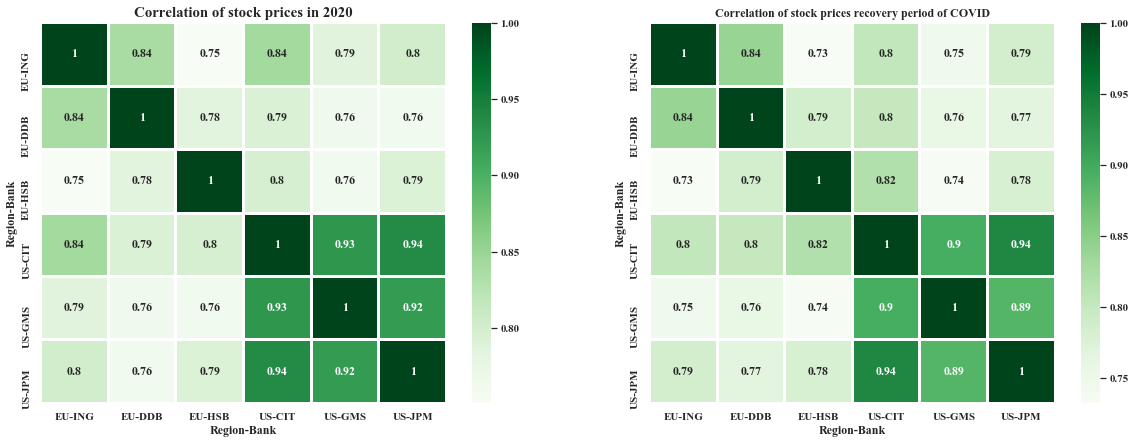

In [75]:
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(20,7))
sns.heatmap(stocks_COVID_close_change.loc[dates_COVIDrec].corr(),annot=True,ax=axes[1],linewidths=2,cmap='Greens')
axes[1].set_title('Correlation of stock prices recovery period of COVID')
sns.heatmap(stocks_COVID_close_change.corr(),annot=True,ax=axes[0],linewidths=2,cmap='Greens')
axes[0].set_title('Correlation of stock prices in 2020',fontsize=15)


It can be seen that the stocks of the US banks are very much correlated during the COVID crisis - this was certianly not the case during the FC were some of the banks were hit much harder that others. This is quite logical since some of the banks were the direct responsible for the FC and can therefore not be considered as 'general'.

In [76]:
ax=plt.figure()
ax=stocks_COVID_close.droplevel('Region', axis=1).iplot()

<Figure size 432x288 with 0 Axes>

In [77]:
dates_COVIDrec_2 = (stocks_COVID_close_change.index > datetime.datetime(2020,3,23)) & (stocks_COVID_close_change.index <= datetime.datetime(2020,7,1))
stocks_COVID_close[dates_COVIDrec_2]
ax=plt.figure()
ax=stocks_COVID_close[dates_COVIDrec_2].droplevel('Region', axis=1).iplot()

<Figure size 432x288 with 0 Axes>

Now I have identified the recovery period, let's again perform some linear fits and compare them to the FC.

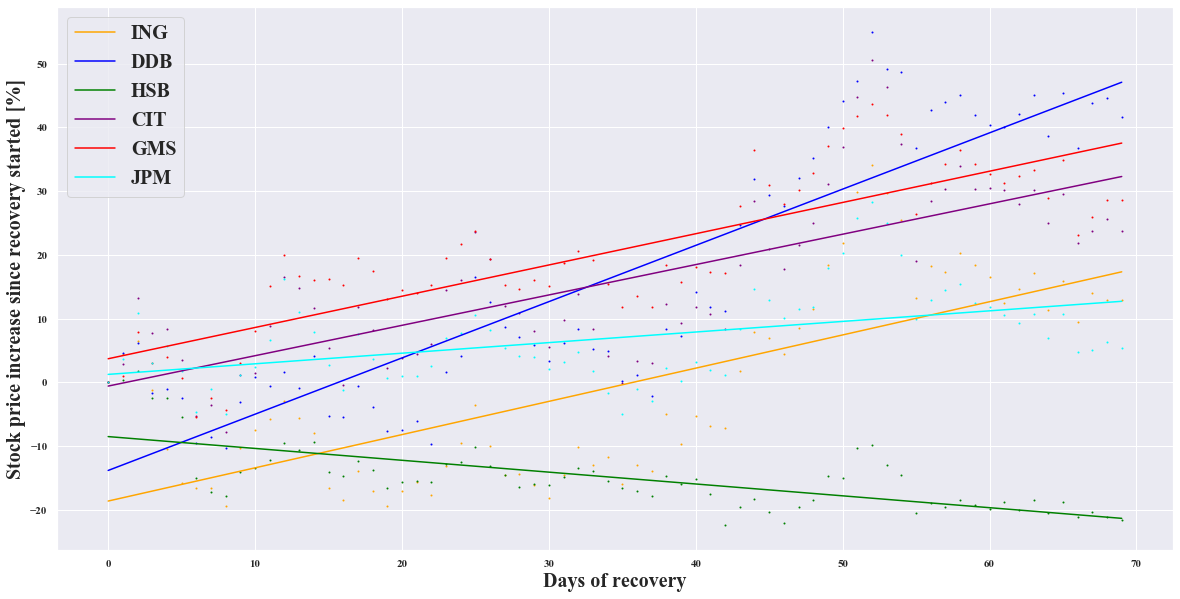

In [78]:
stocks_COVID_close = stocks_COVID_close.droplevel(level='Region',axis=1)
colors=['orange','blue','green','purple','red','cyan']
plt.figure(figsize=(20,10))
lin_coef_COVID=[]

for i in range(0,len(banks)):
    price = (stocks_COVID_close[dates_COVIDrec_2][banks[i]].values/stocks_COVID_close[dates_COVIDrec_2][banks[i]].values[0]-1)*100
    days_from_start = np.arange(0,len(price))
    linFit = np.polyfit(days_from_start,price,1)
    lin_coef_COVID.append(linFit[0])
    
    plt.scatter(days_from_start,price,c=colors[i],s=1)
    plt.plot([days_from_start[0],days_from_start[-1]],[linFit[0]*days_from_start[0]+linFit[1],linFit[0]*days_from_start[-1]+linFit[1]],c=colors[i],label=banks[i])
    plt.legend(fontsize=20)
    plt.ylabel('Stock price increase since recovery started [%]', fontsize=20)
    plt.xlabel('Days of recovery', fontsize=20)

All banks are clearly recovering except HSB. Let's now compare the coefficients for both crises:

In [79]:
linCoeffs=pd.DataFrame(np.hstack((np.reshape(lin_coef_FC,(-1,1)), np.reshape(lin_coef_COVID,(-1,1)))),index=banks,columns=['FC','COVID'])
linCoeffs

,FC,COVID
ING,1.766863,0.521106
DDB,0.666457,0.882570
HSB,0.759013,-0.185859
CIT,0.521564,0.476396
GMS,0.568533,0.490258
JPM,0.525035,0.166141


From the above it can be concluded that the recovery of banks stocks in the COVID crisis is much slower to the financial crisis. This is exactly what was just said on RTL-Z - they did not give an explaination for that unfortunately. What is interesting though, is the fact that HSB was recovering quite quickly during the financial crisis while it is very much lacking behind in the COVID crisis. 

Now, again let's consider the predictability for the COVID crisis:

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

linReg_R2=[]
SVR_R2=[]
SVR_GS_R2=[]

forecast_days = np.array([3, 10, 20])
R2_values=np.zeros((len(banks)+1,3*len(forecast_days)))

for j in range(0,len(forecast_days)):
    stocks_COVID_close_pred=stocks_COVID_close[dates_COVIDrec_2].shift(-forecast_days[j])



    for i in range(0,len(banks)):
        X=np.array(stocks_COVID_close[dates_COVIDrec_2][banks[i]])
        X=X[:-forecast_days[j]]

        y=np.array(stocks_COVID_close_pred[banks[i]])
        y=y[:-forecast_days[j]]
        np.shape(y)


        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

        linMod = LinearRegression()
        linMod.fit(X_train.reshape(-1, 1),y_train)
        linReg_R2.append(linMod.score(X_test.reshape(-1, 1),y_test))
        R2_values[i,0+3*j]=linMod.score(X_test.reshape(-1,1),y_test)


        SVRmodel = SVR(kernel='rbf', C=1e3, gamma=0.1)
        SVRmodel.fit(X_train.reshape(-1, 1),y_train)
        SVR_R2.append(SVRmodel.score(X_test.reshape(-1,1),y_test))
        R2_values[i,1+3*j]=SVRmodel.score(X_test.reshape(-1,1),y_test)

        param_grid={'C':[0.1,1,10,100,1000],'gamma':[1,0.1,0.01,0.001,0.0001]}

        GridSVR = GridSearchCV(SVR(), param_grid,verbose=0)
        GridSVR.fit(X_train.reshape(-1,1),y_train)
        SVR_GS_R2.append(GridSVR.score(X_test.reshape(-1,1),y_test))
        R2_values[i,2+3*j]=GridSVR.score(X_test.reshape(-1,1),y_test)
        
        

    R2_values[i+1,0+3*j]=abs(np.mean(linReg_R2))
    R2_values[i+1,1+3*j]=abs(np.mean(SVR_R2))
    R2_values[i+1,2+3*j]=abs(np.mean(SVR_GS_R2))
    
np.shape(R2_values)

(7, 9)

Allright thats correct: 6 banks + an average    x     3times3=9.

Let's create a DF from this:

In [83]:
col_names = [np.array(['3', '3', '3', '10', '10', '10', '20', '20' , '20']),np.array(['linReg', 'SVR', 'SVR_GS', 'linReg', 'SVR', 'SVR_GS','linReg', 'SVR', 'SVR_GS'])]
R2_DF_COVID = pd.DataFrame(abs(R2_values),columns=col_names,index=['ING', 'DDB', 'HSB', 'CIT', 'GMS', 'JPM', 'Average'])
R2_DF_COVID.columns.names=['n_predictionDays','PredictionMethod']
R2_DF_COVID

n_predictionDays         3                            10                      \
PredictionMethod    linReg       SVR    SVR_GS    linReg       SVR    SVR_GS   
ING               0.485719  0.509367  0.539347  0.351376  0.376767  0.413673   
DDB               0.705365  0.788424  0.779206  0.623739  0.702887  0.605919   
HSB               0.449043  0.308068  0.474248  0.003646  0.166673  0.085161   
CIT               0.436887  0.202432  0.218440  0.071685  0.723648  0.261626   
GMS               0.717301  0.297498  0.599204  0.233395  0.103050  0.332191   
JPM               0.366957  0.048906  0.092866  0.025829  0.228009  0.000339   
Average           0.526879  0.342814  0.450552  0.355719  0.176771  0.309054   

n_predictionDays        20                      
PredictionMethod    linReg       SVR    SVR_GS  
ING               0.193590  0.348677  0.216012  
DDB               0.518400  0.544369  0.580062  
HSB               0.102722  0.065826  0.143521  
CIT               0.189383  1.197635  0.098408  
GMS               0.243818  1.980059  0.033057  
JPM               0.004207  0.157465  0.010609  
Average           0.264155  0.052910  0.226341

## Prediction comparison

In this final section I will compare the results from the first sections. These comparison can be used when considering investing in certain banks during the current crisis.

In [84]:
DF_R2=pd.concat([R2_DF_FC, R2_DF_COVID], keys=['FC', 'COVID'])
DF_R2

n_predictionDays         3                            10                      \
PredictionMethod    linReg       SVR    SVR_GS    linReg       SVR    SVR_GS   
FC    ING         0.924391  0.913988  0.913623  0.879241  0.895059  0.900479   
      DDB         0.872410  0.767966  0.870369  0.617268  0.429013  0.595722   
      HSB         0.946415  0.916751  0.942430  0.856981  0.814219  0.824478   
      CIT         0.784765  0.790042  0.795795  0.506529  0.505141  0.506151   
      GMS         0.934127  0.671308  0.923698  0.871972  0.641364  0.854538   
      JPM         0.839898  0.847385  0.839566  0.843535  0.844099  0.847174   
      Average     0.883668  0.817907  0.880913  0.823128  0.753028  0.817835   
COVID ING         0.485719  0.509367  0.539347  0.351376  0.376767  0.413673   
      DDB         0.705365  0.788424  0.779206  0.623739  0.702887  0.605919   
      HSB         0.449043  0.308068  0.474248  0.003646  0.166673  0.085161   
      CIT         0.436887  0.202432  0.218440  0.071685  0.723648  0.261626   
      GMS         0.717301  0.297498  0.599204  0.233395  0.103050  0.332191   
      JPM         0.366957  0.048906  0.092866  0.025829  0.228009  0.000339   
      Average     0.526879  0.342814  0.450552  0.355719  0.176771  0.309054   

n_predictionDays        20                      
PredictionMethod    linReg       SVR    SVR_GS  
FC    ING         0.653393  0.877218  0.870593  
      DDB         0.528122  0.432694  0.490183  
      HSB         0.708348  0.797668  0.805054  
      CIT         0.106679  0.147565  0.197375  
      GMS         0.788973  0.445968  0.777462  
      JPM         0.641805  0.660704  0.681440  
      Average     0.739158  0.688786  0.757563  
COVID ING         0.193590  0.348677  0.216012  
      DDB         0.518400  0.544369  0.580062  
      HSB         0.102722  0.065826  0.143521  
      CIT         0.189383  1.197635  0.098408  
      GMS         0.243818  1.980059  0.033057  
      JPM         0.004207  0.157465  0.010609  
      Average     0.264155  0.052910  0.226341

Let's compare this thoroughly by first considering the *averages*:
    - It can be seen that on average the predictabilty for the FC is much better compared to the COVID crisis. The                      predictability 'score' in the FC is always more than twice as high compared to the COVID crisis.
    - In general, LinReg and SVR_GS perform comparible while SVR is lacking behind. This holds for both crises.
    - What is remarkable is that if we compare the average scores for the 3, 10, and 20 day forecasts for COVID and FC, the drop for COVID is much larger compared to FC. This can be explained by the fact that the COVID crisis is only lasting a couple of weeks and therefore the predictability in the long term drops dramatically.
    

Second, I explore the *EU Banks*:
    - During the FC the EU banks are quite similar in terms of the predictability for all forecast days. However, during the COVID crisis the is everything except true. DDB is far more predictable compared to the others. One should consider that one if one would like to purchage bank stocks.
    - On the longer term (10 and 20 forecast days), SVR appear to get better and better compared to the other models. 

Third, let's consider the US banks:
    - In both crises, GMS is by far the most predictable bank stock. One could consider this when investing.
    - JPM is very unpredictable during the COVID crisis. The reason for this should be investigated further.